In [1]:
from julia import Main, LightPropagation
import matplotlib.pyplot as plt
import json
from helpers.read import Db
import numpy as np
from google.protobuf.json_format import MessageToDict

Main.eval('println("Hello from Julia")')

extractSubarrayByKey = lambda arr, key: [e[key] for e in arr]

def reflectance(rho, layers, n_ext=1.0, z=0.0, a=50.0, large_l=50.0, MaxIter=10000):
    mu_a, mu_s, gs, l, n_med = (
        extractSubarrayByKey(layers, key) for key in ("muA", "muS", "g", "height", "n")
    )
    red_mu_s = [i*(1 - g) for i, g in zip(mu_s, gs)]
    l[-1] = large_l

    return LightPropagation.flux_DA_Nlay_cylinder_CW(
        rho,
        mu_a,
        red_mu_s,
        n_ext=n_ext,
        n_med=n_med,
        l=l,
        a=a,
        z=z,
        MaxIter=MaxIter
    )

Hello from Julia


In [ ]:
def tf_fun(rho, mu_a, red_mu_s, n_ext, n_med, l, a, z, MaxIter):
    LightPropagation.flux_DA_Nlay_cylinder_CW(
        rho,
        mu_a,
        red_mu_s,
        n_ext=n_ext,
        n_med=n_med,
        l=l,
        a=a,
        z=z,
        MaxIter=MaxIter
    )

In [2]:
db_name = 'fixed_n_high_precision'
db  = Db('./' + db_name + '.db')
gen = db.rows()

def format_layer(layer):
    return MessageToDict(layer)    

def format_doc(reflectance, layers, dists):
    return {
        "layers": [format_layer(layer) for layer in layers],
        "reflectance": reflectance,
        "dists": dists
    }


docs = []

for sim in gen:
    ref = np.asarray(sim.reflectance)
    abs = np.asarray(sim.absorption).reshape((100, 100))

    radial_extent = sim.details.radialExtent
    dists = np.linspace(radial_extent.min, radial_extent.max, radial_extent.bins)

    docs.append(format_doc(ref, sim.details.layers, dists))

In [3]:
n_docs = 20
relevant_docs = docs[:n_docs]

for doc in relevant_docs:
    doc["de_reflectance"] = np.array([reflectance(d, doc["layers"]) for d in dists])

layer 0, muS/muA 4.117450813675405


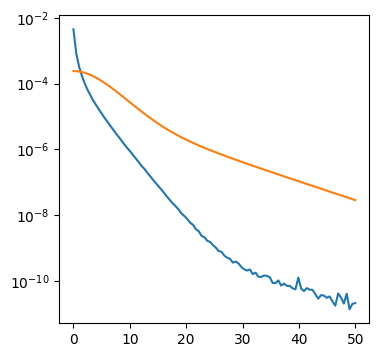

layer 0, muS/muA 13.392597530591242


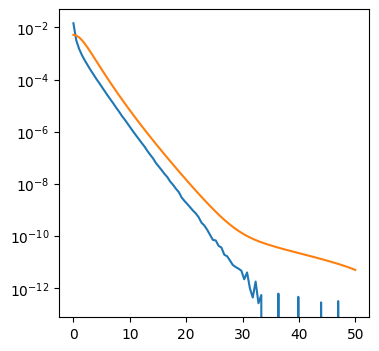

layer 0, muS/muA 20.652467874878667


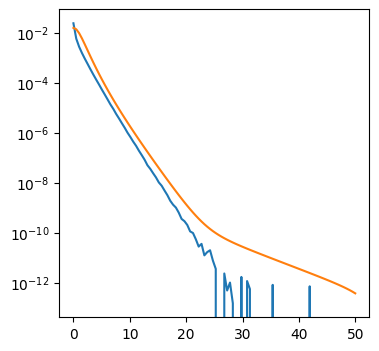

layer 0, muS/muA 36.4611301328588


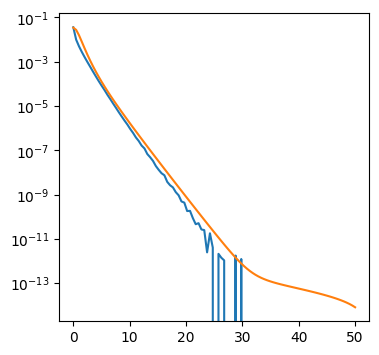

layer 0, muS/muA 10.924855962695295


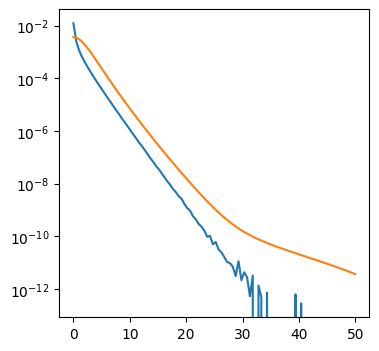

layer 0, muS/muA 11.547982279128377


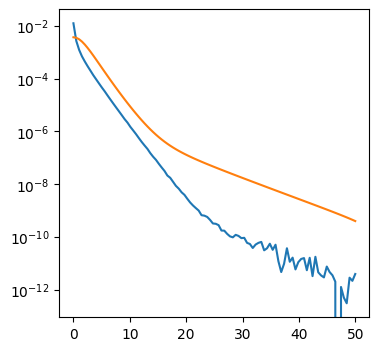

layer 0, muS/muA 51.293788680669955


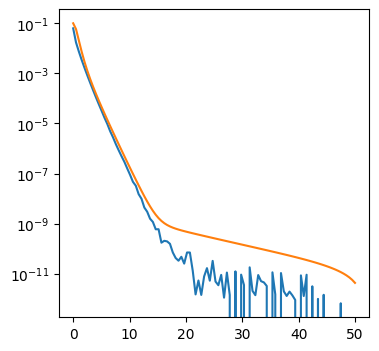

layer 0, muS/muA 31.739528624074726


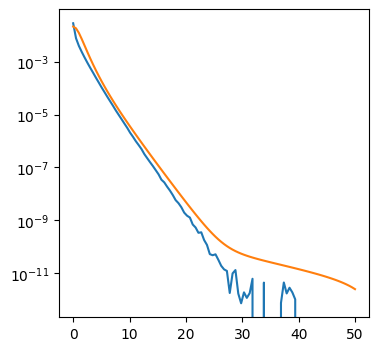

layer 0, muS/muA 75.07686089377715


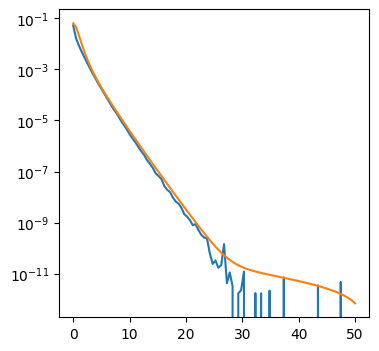

layer 0, muS/muA 9.5845670500448


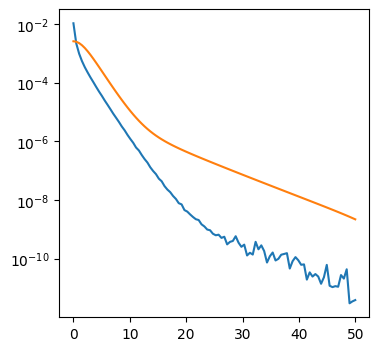

layer 0, muS/muA 15.24277353903623


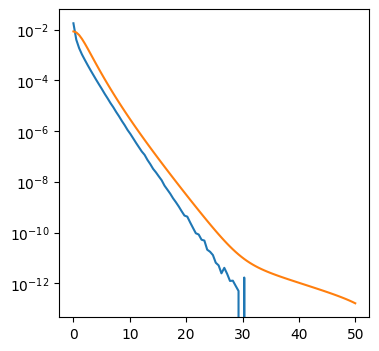

layer 0, muS/muA 39.60413897492549


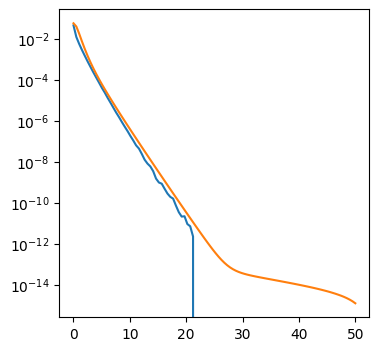

layer 0, muS/muA 181.7625573584469


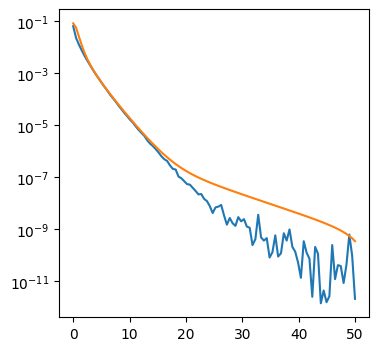

layer 0, muS/muA 73.45009269230087


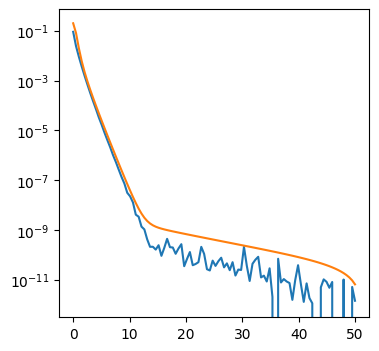

layer 0, muS/muA 130.7680225048249


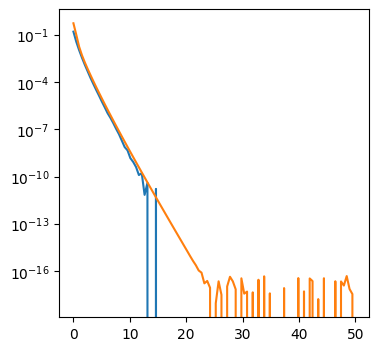

layer 0, muS/muA 145.76107591933723


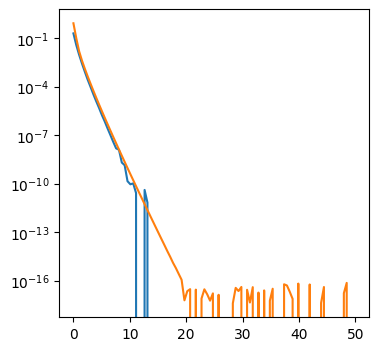

layer 0, muS/muA 143.25589367720025


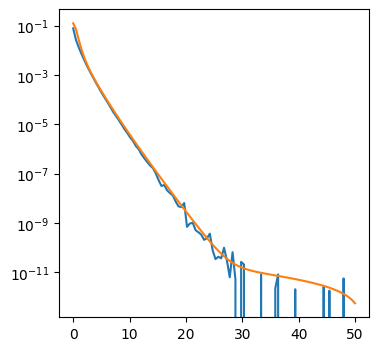

layer 0, muS/muA 141.21714093015987


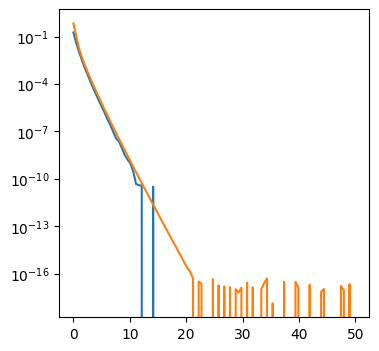

layer 0, muS/muA 119.24946235715296


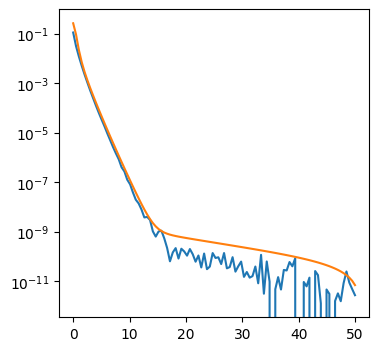

layer 0, muS/muA 74.20040053928018


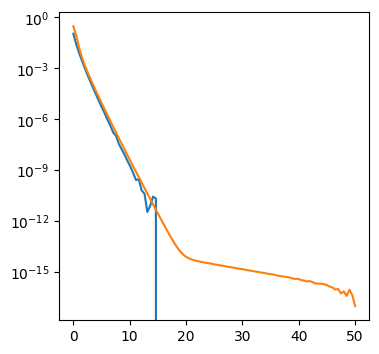

In [4]:
for doc in relevant_docs:
    x = doc["dists"]
    y = doc["reflectance"]
    y_pred = doc["de_reflectance"]

    layer_0 = doc["layers"][0]
    print("layer 0, muS/muA", layer_0["muS"]/layer_0["muA"])

    plt.figure(figsize=(4,4))
    plt.plot(x, y)
    plt.plot(x, y_pred)
    plt.yscale('log')
    plt.show()

In [5]:
relevant_docs[0]["layers"]

[{'n': 1.4,
  'height': 12.104339961968565,
  'muA': 0.27061534653453434,
  'muS': 1.1142453787816702,
  'g': 0.9},
 {'n': 1.4, 'height': 4.292721919669325, 'muA': 0.0, 'muS': 0.2, 'g': 0.9},
 {'n': 1.4,
  'height': 'Infinity',
  'muA': 0.5149280012636193,
  'muS': 30.373345564753993,
  'g': 0.9}]